In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from nltk.corpus import wordnet as wn

In [2]:
def wordnet_graph(words):
     
    """
    Construct a semantic graph and labels for a set of object categories using 
    WordNet and NetworkX. 

    Parameters: 
    ----------
     words : set
         Set of words for all the categories. 

     Returns: 
     -------
     graph : graph
         Graph object containing edges and nodes for the network. 
     labels : dict
         Dictionary of all synset labels. 
     """
     
    graph = nx.DiGraph()
    labels = {}
    seen = set()

    def recurse(s):

        """ Recursively move up semantic hierarchy and add nodes / edges """  

        if not s in seen:                               # if not seen...
            seen.add(s)                                 # add to seen
            graph.add_node(s.name)                      # add node
            labels[s.name] = s.name().split(".")[0]     # add label
            hypernyms = s.hypernyms()                   # get hypernyms

            for s1 in hypernyms:                        # for hypernyms
                graph.add_node(s1.name)                 # add node
                graph.add_edge(s.name, s1.name)         # add edge between
                recurse(s1)                             # do so until top

    # build network containing all categories          
    for word in words:                                  # for all categories
        s = wn.synset(str(word) + str('.n.01'))         # create synset            
        recurse(s)                                      # call recurse

    # return the graph and labels    
    return graph, labels

In [3]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='********',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_wn18rr')

In [4]:
entity = psql.read_sql("SELECT * FROM entity WHERE pos_tag = 'NN'", connection)
entity.head()

,synset_id,name,pos_tag,sense_index,definition
0,14854262,stool,NN,2,solid excretory product evacuated from the bowels
1,00590383,chieftainship,NN,1,the position of chieftain
2,08769179,saxony,NN,1,an area in Germany around the upper Elbe river...
3,02338145,ondatra zibethica,NN,1,beaver-like aquatic rodent of North America wi...
4,11812094,rose campion,NN,1,an old cottage garden plant of southeastern Eu...


In [5]:
entity_sample = entity.sample(n=10)['name']
entity_sample

26999                pepcid
17278         arterial road
24276            field corn
6502        nationalization
20454               solving
16603            difficulty
23339       viburnum opulus
30530    overcapitalization
7706                fasting
18683          spectroscope
Name: name, dtype: object

In [6]:
categories = set()
for sample in entity_sample:
    name = '_'.join(sample.split())
    print(name)
    categories.add(name)

pepcid
arterial_road
field_corn
nationalization
solving
difficulty
viburnum_opulus
overcapitalization
fasting
spectroscope


In [7]:
# create the graph and labels
graph, labels = wordnet_graph(categories)
 
print(f'labels: {labels}')

labels: {<bound method Synset.name of Synset('trouble.n.04')>: 'trouble', <bound method Synset.name of Synset('effort.n.02')>: 'effort', <bound method Synset.name of Synset('labor.n.02')>: 'labor', <bound method Synset.name of Synset('work.n.01')>: 'work', <bound method Synset.name of Synset('activity.n.01')>: 'activity', <bound method Synset.name of Synset('act.n.02')>: 'act', <bound method Synset.name of Synset('event.n.01')>: 'event', <bound method Synset.name of Synset('psychological_feature.n.01')>: 'psychological_feature', <bound method Synset.name of Synset('abstraction.n.06')>: 'abstraction', <bound method Synset.name of Synset('entity.n.01')>: 'entity', <bound method Synset.name of Synset('fast.n.01')>: 'fast', <bound method Synset.name of Synset('abstinence.n.02')>: 'abstinence', <bound method Synset.name of Synset('self-denial.n.02')>: 'self-denial', <bound method Synset.name of Synset('control.n.05')>: 'control', <bound method Synset.name of Synset('overcapitalization.n.01'

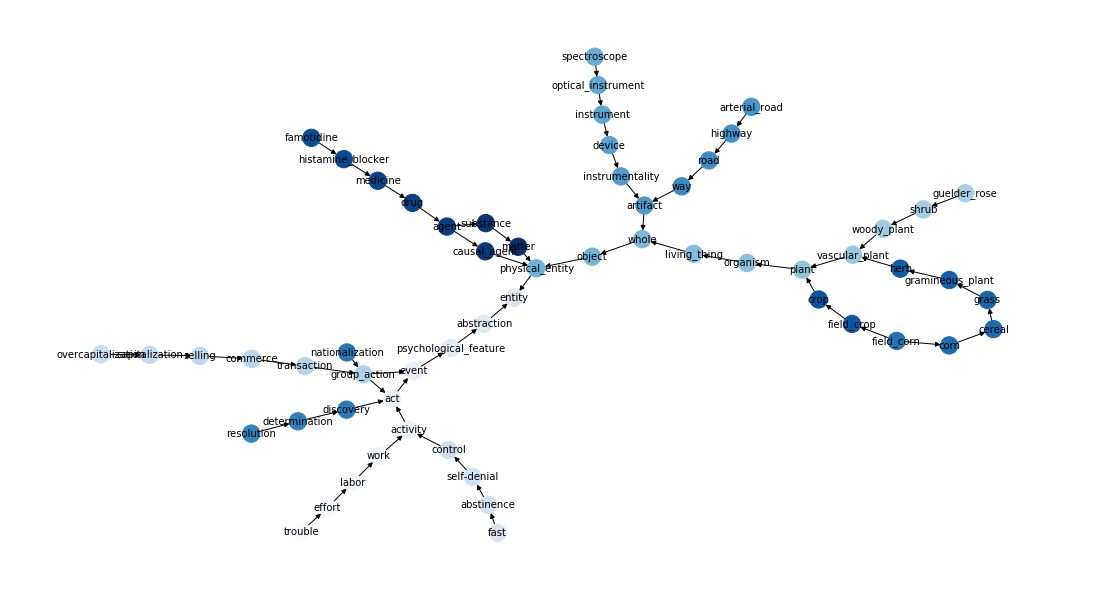

In [9]:
plt.figure(figsize=(15, 8))
# draw the graph
pos=graphviz_layout(graph)
nx.draw(graph, 
        pos=graphviz_layout(graph), 
        labels=labels,
        font_size=10,
        cmap=plt.cm.Blues,
        node_color=range(len(graph)),
        prog='dot')
plt.savefig('WN18RR_Graph.png', format='PNG')
plt.show()